In [5]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo

%matplotlib inline
import matplotlib.pyplot as plt

""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2

import scipy
import json
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the datasets

In [70]:
ROOT_FOLDER = "/datagrid/personal/baljibil"
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_base_multi/IMG-coco_small-Rep-mpii.json') as f:
    annot_mpii_on_coco = json.load(f)
with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_base_multi/IMG-coco_small-Rep-mpii1.json') as f:
    annot_mpii_on_coco1 = json.load(f)
with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_base_multi/IMG-coco_small-Rep-coco.json') as f:
    annot_coco_on_coco = json.load(f)
annot_mpii_on_coco = sorted(annot_mpii_on_coco, key=lambda x: int(x['image_id']))

{'category_id': 1, 'center': [442.864990234375, 208.22999572753906], 'image_id': 397133, 'keypoints': [400.2597351074219, 328.26849365234375, 0.46455109119415283, 456.7212219238281, 267.57550048828125, 0.43957027792930603, 411.2806701660156, 265.8087158203125, 0.4091862142086029, 456.9099426269531, 267.701171875, 0.4243968427181244, 411.7302551269531, 266.37939453125, 0.41755858063697815, 400.0463562011719, 327.96142578125, 0.44831550121307373, 463.5487365722656, 328.63275146484375, 0.4318333566188812, 446.4029846191406, 124.52296447753906, 0.760224461555481, 446.3028869628906, 124.89369201660156, 0.7687438726425171, 450.4719543457031, 69.39332580566406, 0.43284928798675537, 450.7352600097656, 69.35813903808594, 0.4557422995567322, 490.6601867675781, 173.7259063720703, 0.47482505440711975, 473.7726135253906, 134.8800506591797, 0.4521869122982025, 489.8155212402344, 174.5417938232422, 0.4720318615436554, 395.5451354980469, 162.3711395263672, 0.4626126289367676, 417.5307922363281, 175.59

In [69]:
from mmpose.datasets import build_dataloader, build_dataset
from mmcv import Config, DictAction

cfg = Config.fromfile("/datagrid/personal/baljibil/repos/ViTPose/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/ViTPose_base_coco_256x192_multi_head.py")

coco_dataset = build_dataset(cfg.data.test, dict(test_mode=True))
annot_truth = coco_dataset.db
annot_truth = sorted(annot_truth, key=lambda x: int(x['image_file'][-10:][:-4]))

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
=> num_images: 5000
=> load 6352 samples
/datagrid/personal/baljibil/data/COCO/original/val2017/000000397133.jpg
/datagrid/personal/baljibil/data/COCO/original/val2017/000000000139.jpg


In [65]:
points_pred = [item['keypoints'] for item in annot_mpii_on_coco]
points_pred = np.array(points_pred)
points_pred = points_pred.reshape(points_pred.shape[0], 17, 3)
points_gt = [item['joints_3d'] for item in annot_truth]
joints_vis = [item['joints_3d_visible'] for item in annot_truth]
box_center = [item['center'] for item in annot_truth]
box_scale = [item['scale'] for item in annot_truth]
bbox = [item['bbox'] for item in annot_truth]

points_gt = np.array(points_gt)
joints_vis = np.array(joints_vis)
box_center = np.array(box_center)
box_scale = np.array(box_scale)
bbox = np.array(bbox)

print("points_pred: ", points_pred.shape)
print("points_gt: ", points_gt.shape)


points_pred:  (6352, 17, 3)
points_gt:  (6352, 17, 3)


### Check if images are correctly aligned.

In [66]:
print(annot_mpii_on_coco[0]['image_id'])
print(annot_truth[0]['image_file'][-10:][:-4])
wrong = 0
for i in range(len(annot_truth) - 6000):
  if int(annot_truth[i]['image_file'][-10:][:-4]) != int(annot_mpii_on_coco[i]['image_id']):
    wrong += 1

139
000139


In [68]:
annot_mpii_on_coco[0]

{'category_id': 1,
 'center': [438.82501220703125, 226.11500549316406],
 'image_id': 139,
 'keypoints': [452.466064453125,
  284.4084777832031,
  0.6266149282455444,
  447.61260986328125,
  221.211181640625,
  0.39091041684150696,
  442.8573303222656,
  252.95419311523438,
  0.3754611015319824,
  451.65533447265625,
  252.30169677734375,
  0.4192226529121399,
  452.4229736328125,
  221.83157348632812,
  0.3690720200538635,
  449.92218017578125,
  221.52688598632812,
  0.39664414525032043,
  456.7508544921875,
  283.9429626464844,
  0.43589621782302856,
  440.8079833984375,
  178.06640625,
  0.8696290850639343,
  440.927001953125,
  178.07406616210938,
  0.8326277732849121,
  430.36138916015625,
  216.68972778320312,
  0.4588957130908966,
  421.7873229980469,
  213.13995361328125,
  0.45430171489715576,
  439.62847900390625,
  177.68356323242188,
  0.4704494774341583,
  437.41436767578125,
  194.49435424804688,
  0.44452837109565735,
  439.5201416015625,
  177.49197387695312,
  0.480143

COCO Eval doesn't care about order and it uses img-id as a sorting key for ordering. Im not sure 5 persons 1 image are sorted. I'm assuming they came from mmpose as sorted in the order it came from annotations thus, we are respecting order of images in annotations in bbox. Thus use stable sorting.

In [77]:
annot_truth[img_idx]

{'image_file': '/datagrid/personal/baljibil/data/COCO/original/val2017/000000005193.jpg',
 'center': array([109.81, 254.5 ], dtype=float32),
 'scale': array([1.54425, 2.059  ], dtype=float32),
 'bbox': [1.91, 89.78, 215.8, 329.44000000000005],
 'rotation': 0,
 'joints_3d': array([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 87., 264.,   0.],
        [  0.,   0.,   0.],
        [192., 307.,   0.],
        [ 27., 219.,   0.],
        [134., 210.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], dtype=float32),
 'joints_3d_visible': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [1., 1.

000000000139
[427. 170.   0.]
[429. 169.   0.]
[0. 0. 0.]
[434. 168.   0.]
[0. 0. 0.]
[441. 177.   0.]
[446. 177.   0.]
[437. 200.   0.]
[430. 206.   0.]
[430. 220.   0.]
[420. 215.   0.]
[445. 226.   0.]
[452. 223.   0.]
[447. 260.   0.]
[454. 257.   0.]
[455. 290.   0.]
[459. 286.   0.]


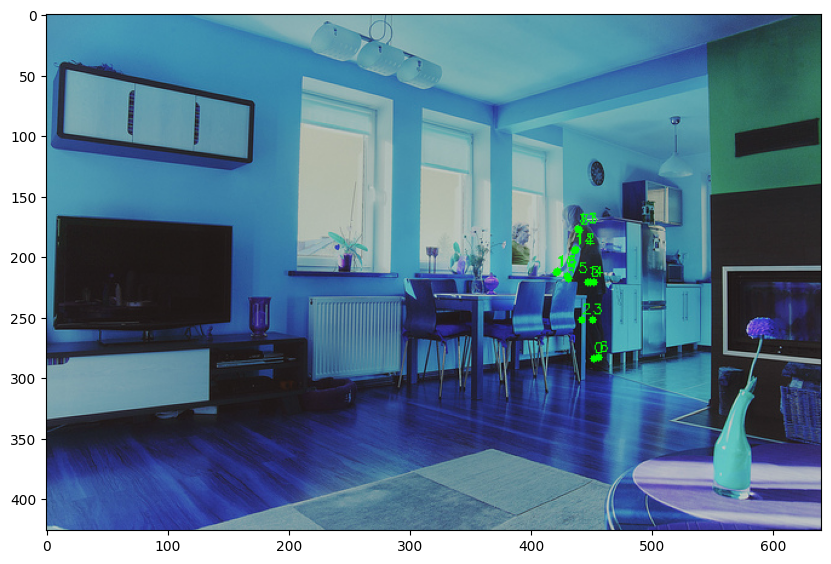

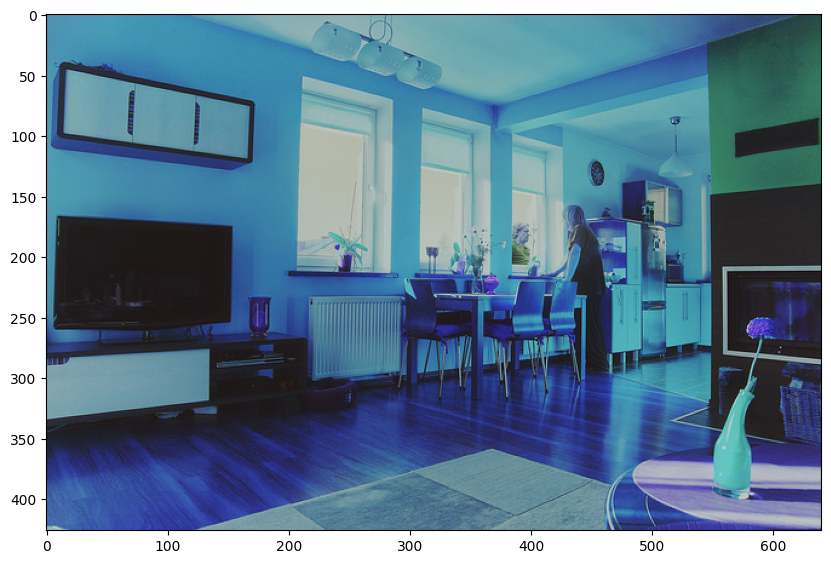

In [82]:
img_idx = 0
instance = annot_mpii_on_coco[img_idx]
# 12 - width?
img_name = ""
for i in range(12 - len(str(instance['image_id']))):
  img_name += "0"
img_name += str(instance['image_id'])
print(img_name)

image = cv2.imread(ROOT_FOLDER + '/data/COCO/original/val2017/' + f"{img_name}.jpg")

for i in range(0,len(instance['keypoints']), 3):
  kp = instance['keypoints']
  x, y = int(kp[i]), int(kp[i+1])
  cv2.circle(image, (x, y), 3, (0, 255, 0, 150), -1)
  cv2.putText(image, str(i//3), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)  # Label the index
plt.figure(figsize=(10, 10))
plt.imshow(image)

instance = annot_truth[img_idx]
image1 = cv2.imread(ROOT_FOLDER + '/data/COCO/original/val2017/' + f"{img_name}.jpg")
for i in range(0,len(instance['joints_3d'])):
  kp = instance['joints_3d']
  print(kp[i])
  x, y = int(kp[i][0]), int(kp[i][1])
  cv2.circle(image1, (x, y), 3, (0, 255, 0, 150), -1)
  cv2.putText(image1, str(i//3), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)  # Label the index

plt.figure(figsize=(10, 10))
plt.imshow(image1)

In [7]:
print(lo(bbox))

array[6352, 4] n=25408 (0.2Mb) x∈[0., 639.000] μ=171.723 σ=134.745


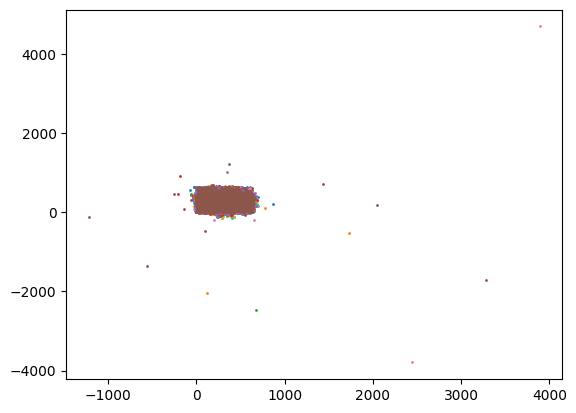

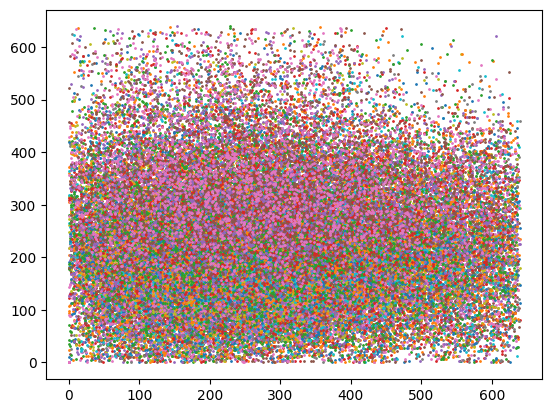

In [8]:
for i in range(16):
  plt.scatter(points_pred[:, i, 0],points_pred[:, i, 1], s=1)
plt.show()

for i in range(17):
  plt.scatter(points_gt[:, i, 0],points_gt[:, i, 1], s=1)
plt.show()

In [9]:
lo(points_pred[:,:, :-1])

array[6352, 17, 2] n=215968 (1.6Mb) x∈[-4.278e+03, 4.667e+06] μ=307.053 σ=1.279e+04

In [10]:
lo(points_gt[:,:,:-1])

array[6352, 17, 2] f32 n=215968 (0.8Mb) x∈[0., 639.000] μ=164.219 σ=166.958

In [11]:
coco_dataset.db

[{'image_file': '/datagrid/personal/baljibil/data/COCO/original/val2017/000000397133.jpg',
  'center': array([442.865, 208.23 ], dtype=float32),
  'scale': array([1.2966563, 1.728875 ], dtype=float32),
  'bbox': [388.66, 69.92, 108.41000000000003, 276.62],
  'rotation': 0,
  'joints_3d': array([[433.,  94.,   0.],
         [434.,  90.,   0.],
         [  0.,   0.,   0.],
         [443.,  98.,   0.],
         [  0.,   0.,   0.],
         [420., 128.,   0.],
         [474., 133.,   0.],
         [396., 162.,   0.],
         [489., 173.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [419., 214.,   0.],
         [458., 215.,   0.],
         [411., 274.,   0.],
         [458., 273.,   0.],
         [402., 333.,   0.],
         [465., 334.,   0.]], dtype=float32),
  'joints_3d_visible': array([[1., 1., 0.],
         [1., 1., 0.],
         [0., 0., 0.],
         [1., 1., 0.],
         [0., 0., 0.],
         [1., 1., 0.],
         [1., 1., 0.],
         [1., 1., 0.]

In [12]:
bbox_left = bbox[:, :-2]
bbox_wh = bbox[:, -2:]
lo(bbox_wh)

array[6352, 2] n=12704 (99Kb) x∈[11.810, 639.000] μ=161.335 σ=122.891

In [13]:

def normalize(data, bbox, joints_vis):
    # Ensure data type consistency
    data = data.astype(np.float32)
    bbox = bbox.astype(np.float32)
    joints_vis = joints_vis.astype(np.float32)
    
    # data [N, 17, 3]
    _data = data[:, :, :-1]
    _data_scores = data[:, :, -1]
    _joints_vis = joints_vis[:, :, :-1]

    bbox_left = bbox[:, :-2]
    bbox_wh = bbox[:, -2:]
    _data = (_data - bbox_left[:, np.newaxis]) * _joints_vis
    _data = _data / bbox_wh[:, np.newaxis]
    return np.concatenate((_data, np.expand_dims(_data_scores, axis=-1)), axis=-1, dtype=np.float32)

def unnormalize(data, bbox, joints_vis):
    # Ensure data type consistency
    data = data.astype(np.float32)
    bbox = bbox.astype(np.float32)
    joints_vis = joints_vis.astype(np.float32)
    
    # data [N, 17, 3]
    _data = data[:, :, :-1]
    _data_scores = data[:, :, -1]
    _joints_vis = joints_vis[:, :, :-1]

    bbox_left = bbox[:, :-2]
    bbox_wh = bbox[:, -2:]

    _data = _data * bbox_wh[:, np.newaxis]
    _data = _data + (bbox_left[:, np.newaxis] * _joints_vis)
    
    return np.concatenate((_data, np.expand_dims(_data_scores, axis=-1)), axis=-1, dtype=np.float32)


# Normalize data
X_normalized = normalize(points_pred, bbox, np.ones_like(points_pred))
y_normalized = normalize(points_gt, bbox, joints_vis)

# Debugging output


### Check normalize & unnormalize
- $x = f^{-1}( f(x) )$

In [14]:
identity = normalize(
      unnormalize(points_pred, bbox, np.ones_like(points_pred))
      , bbox, np.ones_like(points_pred))

# Find elements that are not equal
print("Diff: ", (identity - points_pred).sum())

identity =normalize(
      unnormalize(points_gt, bbox, joints_vis)
      , bbox, joints_vis)

print("Diff: ", (identity - points_gt).sum())


Diff:  -0.0017602367443032563
Diff:  -0.0014595985


In [15]:
print(lo(X_normalized))
print(lo(y_normalized))

array[6352, 17, 3] f32 n=323952 (1.2Mb) x∈[-28.042, 1.938e+04] μ=0.639 σ=40.961
array[6352, 17, 3] f32 n=323952 (1.2Mb) x∈[-1.424, 2.626] μ=0.202 σ=0.297


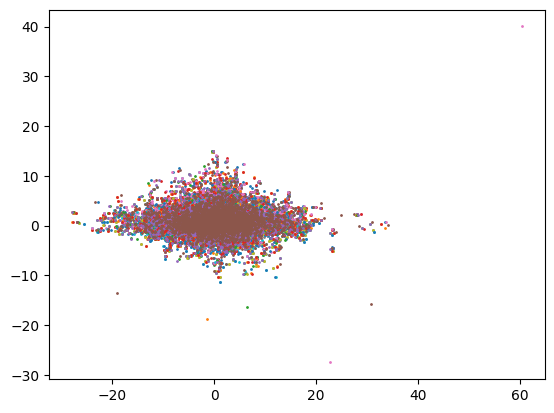

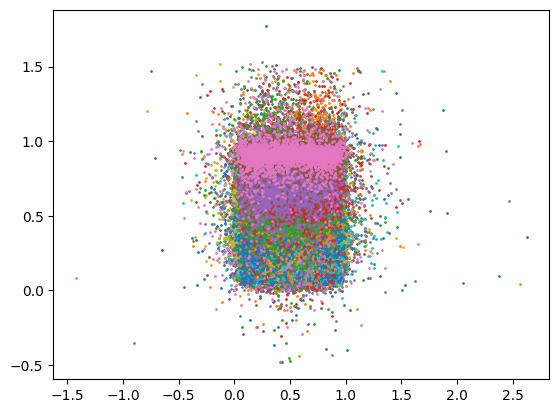

In [16]:

for i in range(16):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(17):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

In [17]:
bbox[0]

array([388.66,  69.92, 108.41, 276.62])

## Evaluate with OKS(Object Keypoints Similarity) for AP

$$ OKS = \Sigma_{i} [exp(\frac{-d_{i}^{2}}{2s^{2}k_{i}^2}) \delta(v_{i}>0)] / \Sigma_{i} [\delta(v_{i}>0)]  $$
- where $d_{i}$ is euclidian distance for $i^{th}$ point
- where $s$ is the object scale and $k_{i}$ is a per-keypont constant that controls falloff
- where $v_{i}$ is visibility flag for $i^{th}$ keypoint

In [30]:
# Given prediction and ground truth with of Nx17x2, where N is sample num return PCKh-ish score.
def calculateAccuracy(preds, gts, joints_vis):
  """
  Will only work on normalized values
  """
  _preds = preds[:,:,:-1]
  _gts = gts[:,:,:-1]

  visib = joints_vis[:,:,:-1]

  distance = np.linalg.norm(_preds - _gts, axis=-1)
  distance = distance * visib[:,:,0].astype(bool).astype(int)
  total_points = visib[:,:,0]
  total_vis = total_points > 0
  total_unvis = total_points == 0
  under_threshold = distance < 0.1
  
  return (under_threshold.sum() - total_unvis.sum())  / total_vis.sum()
# Example usage
acc = calculateAccuracy(y_normalized, y_normalized, joints_vis)
print(acc)
# ap_score = calculate_ap(points_pred, points_gt, bbox)
# print("Average Precision (AP) score:", ap_score)

# coco_dataset._do_python_keypoint_eval("/datagrid/personal/baljibil/repos/scripts/data/from_vitpose_base_multi/IMG-coco_small-Rep-coco.json")



    
  

1.0


[{'category_id': 1,
  'center': [442.864990234375, 208.22999572753906],
  'image_id': 397133,
  'keypoints': [400.2597351074219,
   328.26849365234375,
   0.46455109119415283,
   456.7212219238281,
   267.57550048828125,
   0.43957027792930603,
   411.2806701660156,
   265.8087158203125,
   0.4091862142086029,
   456.9099426269531,
   267.701171875,
   0.4243968427181244,
   411.7302551269531,
   266.37939453125,
   0.41755858063697815,
   400.0463562011719,
   327.96142578125,
   0.44831550121307373,
   463.5487365722656,
   328.63275146484375,
   0.4318333566188812,
   446.4029846191406,
   124.52296447753906,
   0.760224461555481,
   446.3028869628906,
   124.89369201660156,
   0.7687438726425171,
   450.4719543457031,
   69.39332580566406,
   0.43284928798675537,
   450.7352600097656,
   69.35813903808594,
   0.4557422995567322,
   490.6601867675781,
   173.7259063720703,
   0.47482505440711975,
   473.7726135253906,
   134.8800506591797,
   0.4521869122982025,
   489.8155212402344

## Baseline

In [63]:
def handcraft(mpii_x, coco_y):
  """
  Connecting mergeable points to the correct index
  """
  mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
  # Mergeable points merge
  X_coco = np.ones_like(coco_y)
  # Merge-able points
  for mpii_key, coco_key in mapping.items():
    X_coco[:,coco_key] = mpii_x[:,mpii_key]
  # pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
  
  return X_coco

X_transformed_normalized = handcraft(X_normalized, y_normalized)
print(calculateAccuracy(X_transformed_normalized, y_normalized, joints_vis))
print(X_transformed_normalized[0])
print(y_normalized[0])

0.021769405555962764
[[ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [ 0.9330829   0.37821487  0.47203186]
 [ 0.7850992   0.23483498  0.4521869 ]
 [ 0.06351011  0.33421713  0.46261263]
 [ 0.9408743   0.3752654   0.47482505]
 [ 0.2663111   0.38201562  0.33220494]
 [ 0.57259715 -0.00203116  0.4557423 ]
 [ 0.6295539   0.71499234  0.42439684]
 [ 0.20865849  0.708151    0.4091862 ]
 [ 0.21280555  0.710214    0.41755858]
 [ 0.6278131   0.71453804  0.43957028]
 [ 0.10503046  0.93283725  0.4483155 ]
 [ 0.10699872  0.9339473   0.4645511 ]]
[[ 0.4090028   0.08705083  0.        ]
 [ 0.41822705  0.07259057  0.        ]
 [-0.         -0.          0.        ]
 [ 0.5012452   0.10151111  0.        ]
 [-0.         -0.          0.        ]
 [ 0.28908768  0.20996314  0.        ]
 [ 0.7871967   0.22803847  0.        ]
 [ 0.06770589  0.33287543  0.        ]
 [ 

In [55]:
import json
res_file = 'results/res.json'

rec = []
X_transformed_unnormalized = unnormalize(X_transformed_normalized, bbox, np.ones_like(X_transformed_normalized))
X_transformed_unnormalized[:,:,2] = 1
res_points = X_transformed_unnormalized.reshape(X_transformed_unnormalized.shape[0], 51)
for i in range(len(annot_mpii_on_coco)):

  keypoints = res_points[i].astype(int).tolist()
  rec.append({"image_id": annot_mpii_on_coco[i]['image_id'], 
              "category_id": annot_mpii_on_coco[i]['category_id'], 
              "keypoints": keypoints, 
              "score": 1,})
# X_transformed_normalized

with open(res_file, 'w') as f:
  json.dump(rec, f, indent=4)



In [56]:
coco_dataset._do_python_keypoint_eval("/datagrid/personal/baljibil/repos/scripts/results/res.json")


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=3.01s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.073
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.068
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.244
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

[('AP', 0.012250241454345548),
 ('AP .5', 0.07285953923401467),
 ('AP .75', 0.0010708517660276667),
 ('AP (M)', 0.04146425100024586),
 ('AP (L)', 0.0067375099082756795),
 ('AR', 0.06764798488664987),
 ('AR .5', 0.24370277078085642),
 ('AR .75', 0.02991183879093199),
 ('AR (M)', 0.06678503141218246),
 ('AR (L)', 0.06900780379041248)]

In [64]:
gt_bbox = bbox.repeat(17, axis=0).reshape((bbox.shape[0], 17, 4))
print(gt_bbox.shape)
gt_y = np.concatenate((y_normalized, gt_bbox), axis=-1)
gt_y.shape
gt_y[:,0,:-3].shape
gt_y.shape

(6352, 17, 4)


(6352, 17, 7)

In [45]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

# gt [N 17 3]
# but we need to pass the bounding boxes for each object as well
gt_bbox = bbox.repeat(17, axis=0).reshape((bbox.shape[0], 17, 4))
gt_y = np.concatenate((y_normalized, gt_bbox), axis=-1)

X_train, X_val, y_train, y_val = train_test_split(X_normalized, gt_y, test_size=0.2, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64)


Train instance:  5081
Val instance:  1271
torch.Size([5081, 17, 3])
torch.Size([5081, 17, 7])
torch.Size([1271, 17, 3])
torch.Size([1271, 17, 7])


In [221]:
# Given prediction and ground truth with of Nx16x2, where N is sample num return PCKh score.
def calculatePCKh(predict, gt):
    return 0
calculatePCKh(y_normalized, y_normalized)

0

In [222]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.layers = nn.Sequential(nn.Flatten(),
                                     nn.Linear(2*16,512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 2*17)
                                     )
    def forward(self, x):
        x = self.layers(x)
        return x.view(-1, 17, 2)

def init_model():
    return TranslatorNN().to(device)

In [223]:
def train_model(model, lr=0.01, max_epoch=100, logs=[]):
    criterion = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.9)
    best_epoch = 0
    best_val_loss = 10000000
    best_model = None
    best_accuracy = 0
    # Training loop
    for epoch in range(max_epoch):
        if epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    bbox = targets[:,0, :-3]
                    gt = targets[:,:, -3:]
                    inputs = inputs.to(device)
                    targets = gt.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dataset)
        
            print(f"Epoch [{epoch}/{max_epoch}], Val Loss: {val_epoch_loss:.6f}")
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0
        for inputs, targets in train_loader:
            bbox = targets[:,0, :-3]
            gt = targets[:,:, -3:]
            inputs = inputs.to(device)
            targets = gt.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            with torch.no_grad():
                train_accuracy += (calculatePCKh(outputs, targets))

        epoch_loss = running_loss / len(train_dataset)
        train_accuracy = train_accuracy / (len(train_dataset) / train_loader.batch_size)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_size = 0
        accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                bbox = targets[:,0, :-3]
                gt = targets[:,:, -3:]
                inputs = inputs.to(device)
                targets = gt.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_size += inputs.size(0)
                accuracy += (calculatePCKh(outputs, targets))
        val_epoch_loss = val_loss / len(val_dataset)
        # Cuz batch size is 1?
        accuracy = accuracy / (len(val_dataset) / val_loader.batch_size)
        # For 16 keypoints
        if accuracy > best_accuracy:
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_val_loss = val_loss
            best_accuracy = accuracy
        logs.append((epoch+1,epoch_loss, val_epoch_loss, accuracy))
        if (epoch+1) % 10 == 1:
            print(f"Epoch [{epoch+1}/{max_epoch}], Train Loss: {epoch_loss:.6f}, TAccuracy: {train_accuracy * 100:.2f}%,  Val Loss: {val_epoch_loss:.6f} Accuracy: {accuracy * 100:.2f}%")
    # model at best epoch
    return best_epoch, best_model, best_val_loss, best_accuracy



In [224]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [1e-2]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_accuracy = 0
best_model_logs = []
torch.manual_seed(42)
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []
  model = init_model()
  print(model)
  t_epoch, t_model, t_loss, t_accuracy = train_model(model,lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.4f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
  



1 [{'lr': 0.01, 'epoch': 200}]
Training for param: {'lr': 0.01, 'epoch': 200}
TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): Tanh()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): Tanh()
    (13): Linear(in_features=512, out_features=34, bias=True)
  )
)
Epoch [0/200], Val Loss: 0.314733
Epoch [1/200], Train Loss: 0.276818, TAccuracy: 0.00%,  Val Loss: 0.251426 Accuracy: 0.00%
Epoch [11/200], Train Loss: 0.239324, TAccuracy: 0.00%,  Val Loss: 0.239693 Accuracy: 0.00%
Epoch [21/200], Train Loss: 0.237975, TAccuracy: 0.00%,  Val Loss: 0.239161 Accuracy: 0

In [ ]:
# TODO:
# - implement OKS
# - understand the score for each points. Feed in only quality points
# - start use joint_visibilities. Don't calculate loss for points that are not visible ofc